In [522]:
import ipywidgets as widgets
from IPython.display import display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

warnings.filterwarnings('ignore')

# Modeling Incidence

In this notebook we present modeling of  two metrics of cancer incidence number of tumors located **insitu** per 1000 of totally diagnozed tumors (insitu means that abnormal cells have been found in their place of origin but have not spread to nearby tissues). And number of diagnozed **multiple tumors** per 1000 cases

The following model must reflect ongoing reforms in Ukrainian medical system as well as COVID19 outbreak and full-scale invasion in 2022

In [523]:
st_df = pd.read_csv('./final_dataset/stage_incidence_features.csv')

In [524]:
st_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      384 non-null    int64  
 1   region                    384 non-null    object 
 2   mtumors                   384 non-null    float64
 3   syncmtumors               384 non-null    float64
 4   insitu                    384 non-null    float64
 5   ncervix                   384 non-null    float64
 6   nhospotal_pht             384 non-null    float64
 7   nbeds_pht                 384 non-null    float64
 8   ybeds_pht                 384 non-null    float64
 9   nill_pht                  384 non-null    float64
 10  nvillage_ill_pht          384 non-null    float64
 11  bed_days_pht              384 non-null    float64
 12  dvisits_pht               384 non-null    float64
 13  hvisits_pht               384 non-null    float64
 14  ndoctors_p

In [525]:
st_df = st_df.drop(columns=['tincidence_pht', 'mtumors', 'syncmtumors', 'insitu', 'ncervix', 'nvillage_ill_pht',
                            'hvisits_pht', 'ndialysis_pht', 'ndialysis_pht', 'nbacter_pht', 'polluted_dumps', 
                            'not_cleaned_dumps', 'dumps_not_cleaned_enough', 'num_clearing_plants', 'nphysic_pht'])

In [526]:
st_df.columns

Index(['year', 'region', 'nhospotal_pht', 'nbeds_pht', 'ybeds_pht', 'nill_pht',
       'bed_days_pht', 'dvisits_pht', 'ndoctors_pht', 'nnursing_pht',
       'nx_ray_pht', 'nflurography_pht', 'nradiology_pht', 'nradlab_pht',
       'nсt_pht', 'ncardiogram_pht', 'ndiaglab_pht', 'nbiochem_pht',
       'ncyto_pht', 'nimun_pht', 'nendoscop_pht', 'nultrasound_pht',
       'air_pollution', 'cpi', 'population', 'mtumors_pht', 'syncmtumors_pht',
       'insitu_pht', 'insitu_pti', 'mtumors_pti', 't', 'gdp', 'aging_level',
       'mean_age'],
      dtype='object')

## Events that need to be accounted

1. **2012** - start of reorganization of medical system
2. **2014** - moratorium on reargonization to same existing medical system at the start of the war
3. **2015** - withdrawal of the moratorium 
4. **2017** - **2018** - creation of medical districts
5. **2018** - creation of National Health Service of Ukraine
6. **2020** - out break
7. **2022** - start of full-scale invasion

To model these events variables **reorg**, **morat**, **mdistrict**, **nhsu**, **cov**, **inv** will be added. 
Also interaction varables must be added

In [527]:
st_df['reorg'] = ((st_df.year >= 2012) & (st_df.year < 2014)).astype(int)
# st_df['morat'] = ((st_df.year >= 2014) & (st_df.year < 2015)).astype(int)
st_df['inner'] = ((st_df.year >= 2014) & (st_df.year < 2018)).astype(int)
st_df['nhsu'] = ((st_df.year >= 2018) & (st_df.year < 2019)).astype(int)
st_df['cov'] = ((st_df.year >= 2020) & (st_df.year < 2022)).astype(int)
st_df['inv'] = (st_df.year >= 2022).astype(int)

In [528]:

equipment_variables = [
    'nhospotal_pht', 'nbeds_pht', 'nx_ray_pht', 'nflurography_pht',
    'nradiology_pht', 'nradlab_pht', 'nсt_pht', 'ncardiogram_pht', 'ndiaglab_pht',
    'nbiochem_pht', 'ncyto_pht', 'nimun_pht', 'nendoscop_pht', 'nultrasound_pht',
]

personnel_variables = ['ndoctors_pht', 'nnursing_pht']

illness_variables = ['nill_pht']

environmental_variables = [
    'air_pollution'
]

dummies = ['reorg', 'inner', 'nhsu', 'cov']

economic_variables = ["gdp", "mean_age", "aging_level"]

all_explanatory_variables = equipment_variables + personnel_variables + illness_variables + environmental_variables + economic_variables

all_dependent_variables = ['mtumors_pti']

Also interaction terms must be added

1. Equipment variables must have interaction with **reorg**, **mdistrict**, **nhsu**
2. Personnel varaibles must have interaction with **reorg**, **mdistrict**, **nhsu**, **cov**, **inv**
3. Illness variables must have interaction with **reorg**, **mdistrict**, **nhsu**, **cov**, **inv** 


In [529]:
def add_interactions(df, interactions: list[str], x_names: list[str]):
    interaction_names = []
    for interaction in interactions:
        for x_name in x_names:
            interaction_name = f"{interaction}_{x_name}"
            df[interaction_name] = df[interaction] * df[x_name]
            interaction_names.append(interaction_name)
    return df, interaction_names 

# st_df, _ = add_interactions(st_df, ['reorg', "morat", 'inner', 'mdistrict', 'nhsu', 'cov'], equipment_variables)
# st_df, _ = add_interactions(st_df, ['reorg', "morat", 'inner', 'mdistrict', 'nhsu', 'cov'], personnel_variables)
# st_df, _ = add_interactions(st_df, ['reorg', "morat", 'inner', 'mdistrict', 'nhsu', 'cov'], illness_variables)

## Trend account

In [530]:
st_df['t'] = st_df['year'] - 2008

In [531]:

def coupled_detrend(df: pd.DataFrame, x_names: list[str]):
    df = df.copy()
    years = sorted(df.year.unique())
    for x_name in x_names:
        for year in years:
            x_at_year = df[df.year == year][x_name]
            df.loc[df.year == year, x_name] = x_at_year - x_at_year.mean()
    
    return df


## Quick fixes

In [532]:
st_df = st_df[st_df.year <= 2021]
st_df = st_df[~st_df.region.isin(['Донецька', 'Луганська'])]

## Model selection

In [533]:
def select_best_model_for(df: pd.DataFrame, target: str, ommit: list[str]) -> tuple[sm.OLS, list[str]]:
    predictors = df.drop(columns=ommit + [target], errors="ignore")

    predictors = predictors.select_dtypes(include=["number"])
    
    X = predictors.copy()
    y = df[target]
    
    X = sm.add_constant(X)
    
    best_model = sm.OLS(y, X).fit()

    best_aic = np.inf

    to_drop = None

    while len(X.columns) > 0:
        aic_not_changed = True
            
        for col in X.columns:
            temp_X = X.drop(col, axis = 1)
            temp_model = sm.OLS(y, temp_X).fit()
            if temp_model.aic < best_aic:
                best_aic = temp_model.aic
                best_model = temp_model
                to_drop = col
                aic_not_changed = False

        if aic_not_changed:
            break

        X = X.drop(to_drop, axis = 1)
    
    return best_model



In [534]:
ommit = ["age_group", "year", "region", "category",  'mtumors_pht', 'syncmtumors_pht',
         'insitu_pht', 'insitu_pti', 'mtumors_pti', 'ncervix', 'mtumors', 'syncmtumors', 'insitu', 
         'gdp', 'mtumors_pti', 'tincidence', 'cpi', 'ybeds_pht', 'population']

In [535]:
def get_interpretation_table(params, explanatory_names):

    interpretation_table = {dummy: [] for dummy in dummies}
    interpretation_table.update({"base": None})

    interpretation_table["base"] = [params.get(x_name, 0) for x_name in explanatory_names]

    for dummy in dummies:
        for x_name in explanatory_names:
            total_impact = params.get(x_name, 0) + params.get(f"{dummy}_{x_name}", 0)
            interpretation_table[dummy].append(total_impact)
        
    return pd.DataFrame(interpretation_table, index=explanatory_names)

### Simple model

In [536]:
explanatory_variables = ['ndiaglab_pht', 'ndoctors_pht', 'dvisits_pht',
                        'nсt_pht', 'nimun_pht', 'nradlab_pht', 
                        'nbiochem_pht', 'ncyto_pht',
                        'air_pollution']

dummies = ['reorg','inner', 'nhsu']

variables = explanatory_variables + dummies
df = st_df[variables + all_dependent_variables + ['t', 'year', 'region'] + economic_variables]
df['dvisits_pht'] /= df['ndoctors_pht']


variables += ['mdevindex']

df['mdevindex'] = st_df[['nx_ray_pht', 'nflurography_pht', 'nultrasound_pht']].min(axis=1)

df, interaction_names = add_interactions(df, dummies, explanatory_variables + ['mdevindex'])
df = coupled_detrend(df, variables + all_dependent_variables)


## Multiple regression

In [537]:
# Identify and display the rows where GDP is missing
missing_gdp = df[df['gdp'].isna()][['year', 'region']]


y = df['mtumors_pti']
X = sm.add_constant(df[explanatory_variables + interaction_names + ["mdevindex"]+economic_variables])

mtumors_model = sm.OLS(y, X).fit()

print(mtumors_model.rsquared_adj)
get_interpretation_table(mtumors_model.params, explanatory_variables + ['mdevindex'])

0.47352772772521934


,reorg,inner,nhsu,base
ndiaglab_pht,-0.549033,-1.230425,-0.968986,-0.427364
ndoctors_pht,-0.025393,0.024396,0.072318,0.041164
dvisits_pht,0.027714,0.019131,0.016979,0.017486
nсt_pht,-11.656931,-5.841255,-24.363165,-11.840650
nimun_pht,22.921005,-29.797686,-50.733564,2.561671
nradlab_pht,77.910767,54.149949,29.994839,25.813267
nbiochem_pht,-48.049415,-9.058897,26.816832,-7.529994
ncyto_pht,26.631840,50.068359,9.297521,6.390101
air_pollution,0.014098,0.016773,0.016375,-0.003307
mdevindex,-6.557696,-3.438806,-2.511345,-3.163759


In [538]:
mtumors_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            mtumors_pti   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     8.342
Date:                Sun, 20 Apr 2025   Prob (F-statistic):           1.90e-31
Time:                        18:42:26   Log-Likelihood:                -1261.8
No. Observations:                 352   AIC:                             2612.
Df Residuals:                     308   BIC:                             2782.
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -158.6844     32.525     -4.879      0.000    -222.683     -94.686
ndiaglab_pht           -0.4274      0.366     -1.167      0.244      -1.148       0.293
ndoctors_pht            0.0412      0.035      1.175      0.241      -0.028       0.110
dvisits_pht             0.0175      0.002      7.041      0.000       0.013       0.022
nсt_pht               -11.8407      5.623     -2.106      0.036     -22.906      -0.776
nimun_pht               2.5617      9.744      0.263      0.793     -16.611      21.735
nradlab_pht            25.8133     12.902      2.001      0.046       0.427      51.200
nbiochem_pht           -7.5300      8.565     -0.879      0.380     -24.384       9.324
ncyto_pht               6.3901      8.757      0.730      0.466     -10.841      23.621
air_pollution          -0.0033      0.005     -0.636      0.525      -0.014       0.007
reorg_ndiaglab_pht     -0.1217      0.909     -0.134      0.894      -1.911       1.667
reorg_ndoctors_pht     -0.0666      0.107     -0.624      0.533      -0.276       0.143
reorg_dvisits_pht       0.0102      0.011      0.962      0.337      -0.011       0.031
reorg_nсt_pht           0.1837     23.822      0.008      0.994     -46.691      47.058
reorg_nimun_pht        20.3593     34.084      0.597      0.551     -46.707      87.426
reorg_nradlab_pht      52.0975     46.926      1.110      0.268     -40.239     144.434
reorg_nbiochem_pht    -40.5194     36.358     -1.114      0.266    -112.060      31.021
reorg_ncyto_pht        20.2417     27.464      0.737      0.462     -33.800      74.283
reorg_air_pollution     0.0174      0.015      1.181      0.238      -0.012       0.046
reorg_mdevindex        -3.3939      6.075     -0.559      0.577     -15.348       8.560
inner_ndiaglab_pht     -0.8031      0.693     -1.160      0.247      -2.166       0.560
inner_ndoctors_pht     -0.0168      0.057     -0.297      0.767      -0.128       0.094
inner_dvisits_pht       0.0016      0.005      0.342      0.733      -0.008       0.011
inner_nсt_pht           5.9994     10.516      0.570      0.569     -14.694      26.693
inner_nimun_pht       -32.3594     17.517     -1.847      0.066     -66.828       2.109
inner_nradlab_pht      28.3367     22.765      1.245      0.214     -16.459      73.132
inner_nbiochem_pht     -1.5289     20.609     -0.074      0.941     -42.082      39.024
inner_ncyto_pht        43.6783     16.909      2.583      0.010      10.406      76.950
inner_air_pollution     0.0201      0.009      2.289      0.023       0.003       0.037
inner_mdevindex        -0.2750      3.751     -0.073      0.942      -7.656       7.106
nhsu_ndiaglab_pht      -0.5416      2.601     -0.208      0.835      -5.660       4.577
nhsu_ndoctors_pht       0.0312      0.136      0.229      0.819      -0.237       0.299
nhs

In [539]:
X.shape

(352, 44)

## Tests

In [540]:
import pandas as pd
import statsmodels.api as sm

X = df[variables]  
X = sm.add_constant(X) 

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

         Variable       VIF
0           const  1.000000
1    ndiaglab_pht  1.458102
2    ndoctors_pht  1.668725
3     dvisits_pht  1.421707
4         nсt_pht  1.208110
5       nimun_pht  1.344333
6     nradlab_pht  1.260496
7    nbiochem_pht  1.173441
8       ncyto_pht  1.155970
9   air_pollution  1.348735
10          reorg       NaN
11          inner       NaN
12           nhsu       NaN
13      mdevindex  1.473147


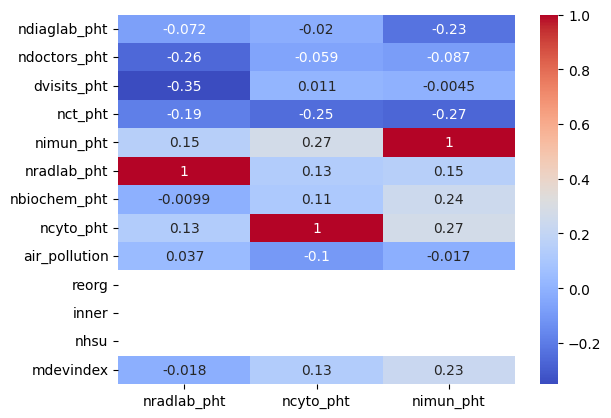

In [541]:
correlation_matrix = df[variables].corr()[['nradlab_pht', 'ncyto_pht', 'nimun_pht']]
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()
# correlation_matrix


In [542]:
from statsmodels.stats.stattools import durbin_watson

# residuals from your model
residuals = mtumors_model.resid  
dw_stat = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw_stat}')

Durbin-Watson statistic: 1.5519439893205864


In [543]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# For raw time series or residuals
ljung_box = acorr_ljungbox(mtumors_model.resid, lags=[10], return_df=True)
ljung_box

,lb_stat,lb_pvalue
10,41.284646,0.00001


---

# GDP